In [2]:
!pip install kaggle
!pip -q install ultralytics==8.3.58 pycocotools==2.0.8

In [3]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

!apt-get update -qq
!apt-get install fonts-nanum* -qq

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings(action='ignore')

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' # 나눔 고딕
font_name = fm.FontProperties(fname=path, size=10).get_name() # 기본 폰트 사이즈 : 10
plt.rc('font', family=font_name)

fm.fontManager.addfont(path)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,794 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126675 files and dire

In [5]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile

os.environ['KAGGLE_USERNAME'] = 'starsin'
os.environ['KAGGLE_KEY'] = 'ff559a02afd29d67f19bc4001d5a69f7'

api = KaggleApi()
api.authenticate()


# 2. 대회 데이터 다운로드
competition_name = "ai05-level1-project"
api.competition_download_files(competition_name, path="./data")



zip_path = "./data/ai05-level1-project.zip"
extract_dir = "./data/ai05-level1-project"

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_dir)

In [50]:
# ============ COCO 조각 병합 → annotations.json → train.json / val.json ============
import os, json, glob
from pathlib import Path
from PIL import Image
from collections import Counter

# --- 경로 설정 (너의 폴더 구조에 맞춰 반영) ---
DATA_ROOT      = "./data/ai05-level1-project"
TRAIN_IMG_DIR  = f"{DATA_ROOT}/train_images"
TRAIN_ANN_DIR  = f"{DATA_ROOT}/train_annotations"   # 하위에 *_json 폴더들
OUT_JSON_ALL   = f"{DATA_ROOT}/annotations.json"    # 병합 산출물
OUT_TRAIN_JSON = f"{DATA_ROOT}/train.json"          # split 결과
OUT_VAL_JSON   = f"{DATA_ROOT}/val.json"

VAL_RATIO = 0.10
SEED      = 42

# --- 유틸 ---
def norm_name(fn: str) -> str:
    """경로/대소문자/공백 등 정규화: 이미지 폴더 기준 file_name로 통일"""
    fn = fn.strip().replace("\\", "/")
    bn = os.path.basename(fn)
    return bn

def file_exists_in_train_images(file_name: str) -> bool:
    return os.path.isfile(os.path.join(TRAIN_IMG_DIR, file_name))

def get_img_size_from_disk(file_name: str):
    p = os.path.join(TRAIN_IMG_DIR, file_name)
    with Image.open(p) as im:
        W, H = im.size
    return int(W), int(H)

def bbox_valid_clip(x, y, w, h, W, H, min_area=1.0):
    """COCO xywh -> 이미지 경계로 클립. 면적 너무 작거나 음수면 None."""
    x = float(max(0.0, x)); y = float(max(0.0, y))
    w = float(max(0.0, w)); h = float(max(0.0, h))
    if w <= 0 or h <= 0:
        return None
    x2 = min(x + w, float(W)); y2 = min(y + h, float(H))
    x1 = min(max(0.0, x), float(W)); y1 = min(max(0.0, y), float(H))
    w2 = max(0.0, x2 - x1); h2 = max(0.0, y2 - y1)
    if w2 * h2 < min_area:
        return None
    return [round(x1, 2), round(y1, 2), round(w2, 2), round(h2, 2)]

def dedup_key(new_img_id: int, cat_id: int, bbox_xywh, prec=1):
    """중복 제거용 키: 같은 이미지/카테고리/라운딩된 bbox는 같은 것으로 간주"""
    x,y,w,h = bbox_xywh
    r = lambda v: round(float(v), prec)
    return (new_img_id, int(cat_id), r(x), r(y), r(w), r(h))

def hash_cat(c):
    """카테고리 충돌 감지용 해시 (id는 제외, 내용 기반)"""
    name = (c.get("name") or "").strip().lower()
    sup  = (c.get("supercategory") or "pill").strip().lower()
    return (name, sup)

# --- 병합 컨테이너 ---
merged = {"images": [], "annotations": [], "categories": []}

# 1) 카테고리 테이블 & 충돌 리포트
cat_by_id = {}
cat_hash_by_id = {}
cat_conflict = []

# 2) 이미지 매핑: file_name -> new_img_id
file_to_new_img_id = {}
image_meta = {}  # new_img_id -> {id, file_name, width, height}
new_img_id = 1

# 3) 어노테이션 수집 상태
ann_id = 1
seen_ann_keys = set()

# 4) 리포트 카운터
cnt = {
    "folders_scanned": 0, "json_scanned": 0,
    "images_declared": 0, "images_kept": 0, "images_missing_file": 0,
    "anns_declared": 0, "anns_kept": 0, "anns_bad_bbox": 0,
    "anns_orphan_image": 0, "anns_dup_removed": 0,
}

# --- 스캔 ---
json_files = []
for root, dirs, files in os.walk(TRAIN_ANN_DIR):
    if not any(d.endswith("_json") for d in dirs) and not root.endswith("_json"):
        # 상위에서 한 번만 세고, 하위 *_json 폴더들에서만 실제 JSON 처리
        pass
    for f in files:
        if f.lower().endswith(".json"):
            json_files.append(os.path.join(root, f))

# 폴더 수 (고유 *_json 루트 기준) 집계
json_roots = sorted({p for p in (Path(p).parents[0] for p in json_files) if str(p).endswith("_json")})
cnt["folders_scanned"] = len(json_roots)

for jp in sorted(json_files):
    cnt["json_scanned"] += 1
    try:
        with open(jp, "r") as fh:
            j = json.load(fh)
    except Exception as e:
        print(f"⚠️ JSON 로드 실패: {jp} ({e})")
        continue

    images = j.get("images", [])
    anns   = j.get("annotations", [])
    cats   = j.get("categories", [])

    # ---- categories 수집 & 충돌 리포트 ----
    for c in cats:
        try:
            cid = int(c["id"])
        except Exception:
            continue
        h = hash_cat(c)
        if cid not in cat_by_id:
            cat_by_id[cid] = {
                "id": cid,
                "name": c.get("name", ""),
                "supercategory": c.get("supercategory", "pill")
            }
            cat_hash_by_id[cid] = h
        else:
            if cat_hash_by_id[cid] != h:
                cat_conflict.append((
                    cid,
                    cat_by_id[cid].copy(),
                    {"id": cid, "name": c.get("name",""), "supercategory": c.get("supercategory","pill")}
                ))

    # ---- images 처리 ----
    id_to_file = {}
    for im in images:
        cnt["images_declared"] += 1
        file_name = norm_name(im.get("file_name") or im.get("imgfile") or "")
        if not file_name:
            continue
        id_to_file[im["id"]] = file_name

        if not file_exists_in_train_images(file_name):
            cnt["images_missing_file"] += 1
            continue

        if file_name not in file_to_new_img_id:
            W,H = get_img_size_from_disk(file_name)
            file_to_new_img_id[file_name] = new_img_id
            image_meta[new_img_id] = {"id": new_img_id, "file_name": file_name, "width": W, "height": H}
            new_img_id += 1
            cnt["images_kept"] += 1

    # ---- annotations 처리 ----
    for a in anns:
        cnt["anns_declared"] += 1
        src_img_id = a.get("image_id")
        file_name = norm_name(id_to_file.get(src_img_id, "") or "")
        if not file_name or file_name not in file_to_new_img_id:
            cnt["anns_orphan_image"] += 1
            continue

        new_id = file_to_new_img_id[file_name]
        W = image_meta[new_id]["width"]; H = image_meta[new_id]["height"]

        bbox = a.get("bbox", None)
        if not bbox or len(bbox) != 4:
            cnt["anns_bad_bbox"] += 1
            continue

        fixed = bbox_valid_clip(bbox[0], bbox[1], bbox[2], bbox[3], W, H)
        if fixed is None:
            cnt["anns_bad_bbox"] += 1
            continue

        try:
            cat_id = int(a["category_id"])
        except Exception:
            continue
        if cat_id not in cat_by_id:
            # 미등록 카테고리면 드랍
            continue

        k = dedup_key(new_id, cat_id, fixed, prec=1)
        if k in seen_ann_keys:
            cnt["anns_dup_removed"] += 1
            continue
        seen_ann_keys.add(k)

        merged["annotations"].append({
            "id": ann_id,
            "image_id": new_id,
            "category_id": cat_id,
            "bbox": fixed,
            "area": round(float(fixed[2]*fixed[3]), 2),
            "iscrowd": int(a.get("iscrowd", 0)),
            "segmentation": a.get("segmentation", []),
        })
        ann_id += 1

# 최종 이미지/카테고리 기록(카테고리는 id 오름차순, 이미지도 새 id 오름차순)
merged["images"] = [image_meta[i] for i in sorted(image_meta)]
merged["categories"] = [cat_by_id[cid] for cid in sorted(cat_by_id)]

# 저장 (annotations.json)
with open(OUT_JSON_ALL, "w", encoding="utf-8") as f:
    json.dump(merged, f, indent=2, ensure_ascii=False)

print("✅ COCO 병합 완료")
print(f"   images: {len(merged['images'])} | anns: {len(merged['annotations'])} | cats: {len(merged['categories'])}")
print("📊 리포트:", cnt)
if cat_conflict:
    print("⚠️ 카테고리 충돌 감지(같은 id 다른 내용). 상위 5개:")
    for row in cat_conflict[:5]:
        cid, oldc, newc = row
        print(f"  id={cid} old={oldc} new={newc}")

# ======================= train/val split (일관 카테고리 유지) =======================
import random
random.seed(SEED)

all_imgs = merged["images"]
all_anns = merged["annotations"]
all_cats = merged["categories"]

img_ids = [im["id"] for im in all_imgs]
random.shuffle(img_ids)
val_n = max(1, int(len(img_ids)*VAL_RATIO))
val_set = set(img_ids[:val_n])
tr_set  = set(img_ids[val_n:])

def subset(image_id_set):
    ims = [im for im in all_imgs if im["id"] in image_id_set]
    ans = [an for an in all_anns if an["image_id"] in image_id_set]
    return {"images": ims, "annotations": ans, "categories": all_cats}

train_json = subset(tr_set)
val_json   = subset(val_set)

with open(OUT_TRAIN_JSON, "w", encoding="utf-8") as f:
    json.dump(train_json, f, indent=2, ensure_ascii=False)
with open(OUT_VAL_JSON, "w", encoding="utf-8") as f:
    json.dump(val_json, f, indent=2, ensure_ascii=False)

print("✅ split 저장 완료")
print(f"   train.json: images={len(train_json['images'])}, anns={len(train_json['annotations'])}")
print(f"   val.json  : images={len(val_json['images'])}, anns={len(val_json['annotations'])}")

✅ COCO 병합 완료
   images: 1489 | anns: 4524 | cats: 73
📊 리포트: {'folders_scanned': 0, 'json_scanned': 4526, 'images_declared': 4526, 'images_kept': 1489, 'images_missing_file': 0, 'anns_declared': 4526, 'anns_kept': 0, 'anns_bad_bbox': 2, 'anns_orphan_image': 0, 'anns_dup_removed': 0}
✅ split 저장 완료
   train.json: images=1341, anns=4068
   val.json  : images=148, anns=456


In [51]:
# ======= 경로 설정 (이 부분만 너의 데이터 구조에 맞게 수정) =======
DATA_ROOT = "./data/ai05-level1-project"
IMG_DIR   = f"{DATA_ROOT}/train_images"
TRAIN_JSON= f"{DATA_ROOT}/train.json"
VAL_JSON  = f"{DATA_ROOT}/val.json"

# 출력 작업 공간
WORK_DIR  = "./work_yolov8"
YOLO_DIR  = f"{WORK_DIR}/yolo_dataset"   # 변환된 YOLO 형식 데이터
os.makedirs(WORK_DIR, exist_ok=True)
os.makedirs(YOLO_DIR, exist_ok=True)
print("DATA_ROOT:", DATA_ROOT)
print("IMG_DIR:", IMG_DIR)
print("TRAIN_JSON:", TRAIN_JSON)
print("VAL_JSON:", VAL_JSON)
print("WORK_DIR:", WORK_DIR)

DATA_ROOT: ./data/ai05-level1-project
IMG_DIR: ./data/ai05-level1-project/train_images
TRAIN_JSON: ./data/ai05-level1-project/train.json
VAL_JSON: ./data/ai05-level1-project/val.json
WORK_DIR: ./work_yolov8


In [32]:

# 디바이스
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

'cuda'

In [52]:
# ======= 전처리: COCO → YOLO 변환 (이미지당 최대 4개 유지: 면적 상위 4개) =======
def _ensure_dirs(yolo_dir):
    for p in [
        f"{yolo_dir}/images/train", f"{yolo_dir}/images/val",
        f"{yolo_dir}/labels/train", f"{yolo_dir}/labels/val",
    ]:
        os.makedirs(p, exist_ok=True)

def _cat_maps(coco_obj):
    cat_ids = sorted(coco_obj.getCatIds())
    catid_to_idx = {cid:i for i,cid in enumerate(cat_ids)}
    idx_to_catid = {i:cid for cid,i in catid_to_idx.items()}
    return catid_to_idx, idx_to_catid, [c['name'] for c in coco_obj.loadCats(cat_ids)]

def _xywh_coco_to_yolo(b, img_w, img_h):
    x,y,w,h = b
    xc = (x + w/2) / img_w
    yc = (y + h/2) / img_h
    return [xc, yc, w/img_w, h/img_h]

def convert_split(coco_json, split, img_dir, yolo_dir, catid_to_idx):
    coco = COCO(coco_json)
    img_ids = coco.getImgIds()
    for iid in img_ids:
        info = coco.loadImgs([iid])[0]
        src = os.path.join(img_dir, info['file_name'])
        dst = os.path.join(yolo_dir, f"images/{split}", info['file_name'])
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        if os.path.exists(src):
            shutil.copy(src, dst)

        # 어노테이션 수집
        anns = coco.loadAnns(coco.getAnnIds(imgIds=[iid]))
        # 면적 상위 4개만 유지
        valid = []
        for a in anns:
            x,y,w,h = a['bbox']
            if w>0 and h>0:
                valid.append((w*h, a))
        valid.sort(key=lambda t: t[0], reverse=True)
        kept = [a for _,a in valid[:4]]

        # YOLO 라벨 작성
        lbl_path = os.path.join(yolo_dir, f"labels/{split}", f"{Path(info['file_name']).stem}.txt")
        os.makedirs(os.path.dirname(lbl_path), exist_ok=True)
        with open(lbl_path, 'w') as lf:
            for a in kept:
                cls = catid_to_idx[a['category_id']]
                xc,yc,ww,hh = _xywh_coco_to_yolo(a['bbox'], info['width'], info['height'])
                lf.write(f"{cls} {xc:.6f} {yc:.6f} {ww:.6f} {hh:.6f}\n")

# 변환 실행
_ensure_dirs(YOLO_DIR)
coco_train = COCO(TRAIN_JSON)
catid_to_idx, idx_to_catid, class_names = _cat_maps(coco_train)
convert_split(TRAIN_JSON, 'train', IMG_DIR, YOLO_DIR, catid_to_idx)
convert_split(VAL_JSON,   'val',   IMG_DIR, YOLO_DIR, catid_to_idx)

# data.yaml 생성
data_yaml = f"""
train: {YOLO_DIR}/images/train
val: {YOLO_DIR}/images/val

nc: {len(class_names)}
names: {class_names}
"""
with open(os.path.join(YOLO_DIR, 'data.yaml'), 'w') as f:
    f.write(data_yaml)
print("✅ COCO→YOLO 변환 완료. data.yaml 생성")

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
✅ COCO→YOLO 변환 완료. data.yaml 생성


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
✅ YOLO 변환 완료
 - data.yaml     : ./work_yolov8/yolo_dataset/data.yaml
 - data_abs.yaml : ./work_yolov8/yolo_dataset/data_abs.yaml


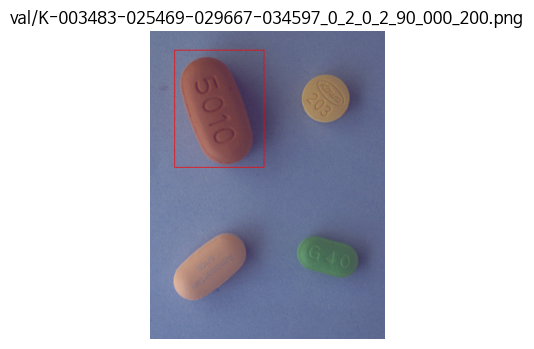

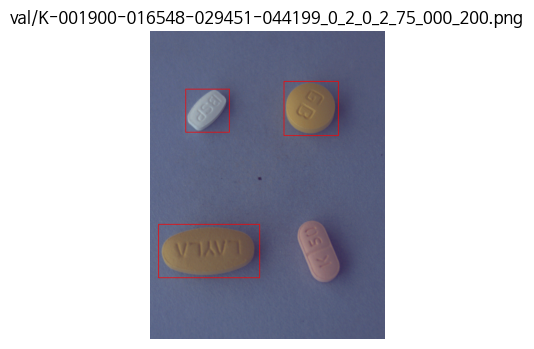

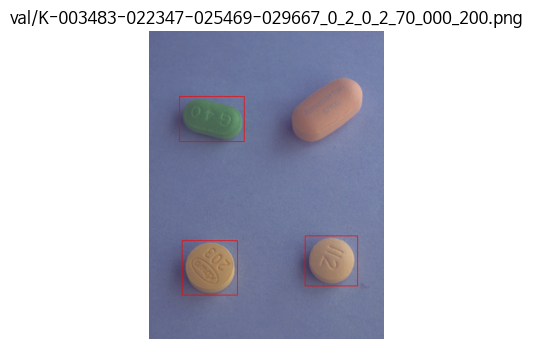

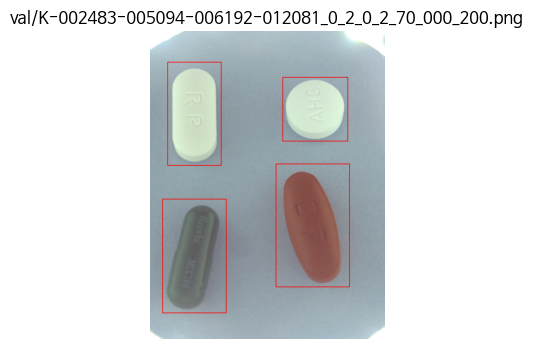

In [53]:
# ===== COCO → YOLO 통합 변환 (면적 상위 4개 유지, 작은 박스 필터, data.yaml + data_abs.yaml 생성, 미리보기) =====
import os, shutil, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image, ImageDraw
from pycocotools.coco import COCO

def _ensure_dirs(yolo_dir: str):
    for p in [f"{yolo_dir}/images/train", f"{yolo_dir}/images/val",
              f"{yolo_dir}/labels/train", f"{yolo_dir}/labels/val"]:
        os.makedirs(p, exist_ok=True)

def _cat_maps(coco_obj: COCO):
    cat_ids = sorted(coco_obj.getCatIds())
    catid_to_idx = {cid: i for i, cid in enumerate(cat_ids)}
    idx_to_catid = {i: cid for cid, i in catid_to_idx.items()}
    class_names = [c["name"] for c in coco_obj.loadCats(cat_ids)]
    return catid_to_idx, idx_to_catid, class_names

def _coco_to_yolo_xywh(x, y, w, h, W, H):
    xc = (x + w/2) / W
    yc = (y + h/2) / H
    return [xc, yc, w/W, h/H]

def _convert_split(coco_json, split, img_dir, yolo_dir, catid_to_idx, *, max_per_image=4, min_area=1.0):
    coco = COCO(coco_json)
    for iid in coco.getImgIds():
        info = coco.loadImgs([iid])[0]
        # 이미지 복사
        src = os.path.join(img_dir, info["file_name"])
        dst = os.path.join(yolo_dir, f"images/{split}", info["file_name"])
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        if os.path.exists(src):
            shutil.copy(src, dst)

        # 어노테이션 → 면적 상위 max_per_image, 너무 작은 박스 제외
        anns = coco.loadAnns(coco.getAnnIds(imgIds=[iid]))
        valid = [(a["bbox"][2]*a["bbox"][3], a) for a in anns
                 if a["bbox"][2] > 0 and a["bbox"][3] > 0 and (a["bbox"][2]*a["bbox"][3]) >= float(min_area)]
        valid.sort(key=lambda t: t[0], reverse=True)
        kept = [a for _, a in valid[:max_per_image]]

        # YOLO 라벨 저장
        lbl_path = os.path.join(yolo_dir, f"labels/{split}", f"{Path(info['file_name']).stem}.txt")
        os.makedirs(os.path.dirname(lbl_path), exist_ok=True)
        with open(lbl_path, "w") as lf:
            for a in kept:
                cls_idx = catid_to_idx[a["category_id"]]
                x,y,w,h = a["bbox"]
                xc,yc,ww,hh = _coco_to_yolo_xywh(x,y,w,h, info["width"], info["height"])
                lf.write(f"{cls_idx} {xc:.6f} {yc:.6f} {ww:.6f} {hh:.6f}\n")

def convert_coco_to_yolo_unified(TRAIN_JSON, VAL_JSON, IMG_DIR, YOLO_DIR, *, max_per_image=4, min_area=1.0):
    _ensure_dirs(YOLO_DIR)
    coco_train = COCO(TRAIN_JSON)
    catid_to_idx, idx_to_catid, class_names = _cat_maps(coco_train)

    _convert_split(TRAIN_JSON, "train", IMG_DIR, YOLO_DIR, catid_to_idx,
                   max_per_image=max_per_image, min_area=min_area)
    _convert_split(VAL_JSON,   "val",   IMG_DIR, YOLO_DIR, catid_to_idx,
                   max_per_image=max_per_image, min_area=min_area)

    # 상대경로 data.yaml + 절대경로 data_abs.yaml 모두 생성(호환성)
    data_yaml_path = os.path.join(YOLO_DIR, "data.yaml")
    with open(data_yaml_path, "w") as f:
        f.write(f"train: {YOLO_DIR}/images/train\n")
        f.write(f"val: {YOLO_DIR}/images/val\n\n")
        f.write(f"nc: {len(class_names)}\n")
        f.write(f"names: {class_names}\n")

    train_abs = os.path.abspath(os.path.join(YOLO_DIR, "images", "train"))
    val_abs   = os.path.abspath(os.path.join(YOLO_DIR, "images", "val"))
    data_yaml_abs = os.path.join(YOLO_DIR, "data_abs.yaml")
    with open(data_yaml_abs, "w") as f:
        f.write(f"train: {train_abs}\n")
        f.write(f"val: {val_abs}\n\n")
        f.write(f"nc: {len(class_names)}\n")
        f.write(f"names: {class_names}\n")

    print("✅ YOLO 변환 완료")
    print(" - data.yaml     :", data_yaml_path)
    print(" - data_abs.yaml :", data_yaml_abs)
    return data_yaml_path, data_yaml_abs, idx_to_catid, class_names

def preview_yolo_labels(yolo_dir, n=4, split="val"):
    img_dir = os.path.join(yolo_dir, "images", split)
    lbl_dir = os.path.join(yolo_dir, "labels", split)
    files = [f for f in os.listdir(img_dir) if f.lower().endswith((".png",".jpg",".jpeg",".bmp",".webp"))]
    for fn in files[:n]:
        img_path = os.path.join(img_dir, fn)
        lbl_path = os.path.join(lbl_dir, f"{Path(fn).stem}.txt")
        if not os.path.exists(lbl_path):
            continue
        img = Image.open(img_path).convert("RGB")
        W,H = img.size
        draw = ImageDraw.Draw(img, "RGBA")
        with open(lbl_path, "r") as lf:
            for ln in lf:
                cls, xc, yc, w, h = ln.strip().split()
                xc, yc, w, h = map(float, (xc, yc, w, h))
                x1 = (xc - w/2) * W; y1 = (yc - h/2) * H
                x2 = (xc + w/2) * W; y2 = (yc + h/2) * H
                draw.rectangle([x1,y1,x2,y2], outline=(255,0,0,255), width=3)
        plt.figure(figsize=(4,4)); plt.imshow(img); plt.axis("off"); plt.title(f"{split}/{fn}"); plt.show()

# 실행
data_yaml_path, data_yaml_abs, idx_to_catid, class_names = convert_coco_to_yolo_unified(
    TRAIN_JSON, VAL_JSON, IMG_DIR, YOLO_DIR,
    max_per_image=4,    # 프로젝트 제약
    min_area=1.0        # 너무 작은 박스 제거
)
preview_yolo_labels(YOLO_DIR, n=4, split="val")

In [36]:
# ===== YOLO data.yaml 절대경로 재작성 + 검증 + 재학습 =====
import os, glob, json
from pycocotools.coco import COCO
from ultralytics import YOLO

# 0) 너가 앞에서 썼던 변수들 사용: WORK_DIR, YOLO_DIR, TRAIN_JSON, VAL_JSON
#    혹시 런타임 리셋했다면 경로를 다시 지정해줘.
YOLO_DIR = os.path.abspath(YOLO_DIR)  # 절대경로로 고정
train_img_dir = os.path.join(YOLO_DIR, "images", "train")
val_img_dir   = os.path.join(YOLO_DIR, "images", "val")

# 1) 클래스 이름 로드 (COCO train.json에서)
coco_train = COCO(TRAIN_JSON)
cat_ids = coco_train.getCatIds()
class_names = [c["name"] for c in coco_train.loadCats(cat_ids)]

# 2) sanity check: 폴더/파일 존재 확인
def count_images(p):
    exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.webp")
    n = 0
    for e in exts:
        n += len(glob.glob(os.path.join(p, e)))
    return n

n_tr = count_images(train_img_dir)
n_va = count_images(val_img_dir)
print(f"[check] train images: {n_tr} | val images: {n_va}")
if n_tr == 0 or n_va == 0:
    raise RuntimeError("images/train 또는 images/val 비어있음. COCO→YOLO 변환 셀을 다시 실행해줘.")

# 3) 절대경로 data.yaml 재작성
data_yaml_path = os.path.join(YOLO_DIR, "data_abs.yaml")
with open(data_yaml_path, "w") as f:
    f.write(f"train: {train_img_dir}\n")
    f.write(f"val: {val_img_dir}\n\n")
    f.write(f"nc: {len(class_names)}\n")
    f.write(f"names: {class_names}\n")
print("✅ wrote:", data_yaml_path)

# (선택) Ultralytics가 '/content/datasets'를 기본 루트로 쓰는 경우 대비해 심볼릭 링크도 같이 걸어두자.
os.makedirs("/content/datasets", exist_ok=True)
link_path = "/content/datasets/pill_yolo_dataset"
if os.path.islink(link_path) or os.path.exists(link_path):
    try:
        os.remove(link_path)
    except:
        pass
try:
    os.symlink(YOLO_DIR, link_path)
    print("🔗 symlink:", link_path, "->", YOLO_DIR)
except FileExistsError:
    pass

# 4) 학습 재시작 (data에 절대경로 yaml 사용)
model = YOLO("yolov8l.pt")
results = model.train(
    data=data_yaml_path,     # << 여기!
    epochs=150,
    imgsz=640,
    batch=16,
    device=0,
    name="pill_yolov8l_max4",
    hsv_h=0.015, hsv_s=0.7, hsv_v=0.5,
    degrees=12.0, translate=0.15, scale=0.6, shear=8.0,
    mosaic=1.0, mixup=0.15
)
print("✅ training started")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
[check] train images: 1340 | val images: 149
✅ wrote: /content/work_yolov8/yolo_dataset/data_abs.yaml
🔗 symlink: /content/datasets/pill_yolo_dataset -> /content/work_yolov8/yolo_dataset
New https://pypi.org/project/ultralytics/8.3.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.58 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/work_yolov8/yolo_dataset/data_abs.yaml, epochs=150, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=pill_yolov8l_max42, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropo

100%|██████████| 22.2M/22.2M [00:00<00:00, 216MB/s]


Overriding model.yaml nc=80 with nc=73

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 374MB/s]


AMP: checks passed ✅


train: Scanning /content/work_yolov8/yolo_dataset/labels/train... 1340 images, 0 backgrounds, 1 corrupt: 100%|██████████| 1340/1340 [00:02<00:00, 555.04it/s]

train: WARNING ⚠️ /content/work_yolov8/yolo_dataset/images/train/K-003351-016262-018357_0_2_0_2_75_000_200.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     6.8878]
train: New cache created: /content/work_yolov8/yolo_dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/work_yolov8/yolo_dataset/labels/val... 149 images, 0 backgrounds, 1 corrupt: 100%|██████████| 149/149 [00:00<00:00, 387.35it/s]

val: WARNING ⚠️ /content/work_yolov8/yolo_dataset/images/val/K-003544-004543-012247-016551_0_2_0_2_70_000_200.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     7.0293]
val: New cache created: /content/work_yolov8/yolo_dataset/labels/val.cache


Plotting labels to runs/detect/pill_yolov8l_max42/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00013, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/pill_yolov8l_max42
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      10.4G      2.072      4.922      2.371        116        640:   1%|          | 1/84 [00:01<02:30,  1.81s/it]

      1/150      10.4G      2.269      5.119      2.657         98        640:   2%|▏         | 2/84 [00:02<01:24,  1.03s/it]
100%|██████████| 755k/755k [00:00<00:00, 136MB/s]
      1/150      10.4G      1.313      3.343      1.569         70        640: 100%|██████████| 84/84 [00:41<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]

                   all        148        471      0.718      0.491       0.56      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      10.3G     0.8531       1.48      1.119         57        640: 100%|██████████| 84/84 [00:39<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]

                   all        148        471      0.675       0.88      0.831      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      10.3G     0.8276      1.241      1.124         52        640: 100%|██████████| 84/84 [00:39<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]

                   all        148        471      0.683      0.878      0.863      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      10.5G     0.7382      1.111      1.069         84        640: 100%|██████████| 84/84 [00:40<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        148        471      0.775      0.883      0.898      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      10.5G     0.7182     0.9834      1.075         60        640: 100%|██████████| 84/84 [00:40<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        148        471      0.696      0.976      0.908      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      10.5G       0.69     0.9114      1.059         85        640: 100%|██████████| 84/84 [00:40<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        148        471      0.687      0.972      0.899      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      10.5G     0.6811     0.8838      1.064         80        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        148        471      0.749      0.966      0.918      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      10.5G     0.6673     0.8349       1.04         58        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        148        471      0.739       0.98      0.936      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      10.5G     0.6502     0.8019      1.039         77        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        148        471      0.741      0.993      0.911      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      10.5G      0.665     0.7837      1.042         77        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        148        471       0.76      0.981      0.917      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      10.5G     0.6241      0.737      1.019         88        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        148        471      0.785      0.982      0.913      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      10.5G     0.6124     0.7519      1.022         93        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        148        471      0.761      0.976      0.904      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      10.5G     0.5768     0.7212      0.995         99        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        148        471      0.746      0.984      0.901      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      10.5G     0.5768     0.7297      1.011         70        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        148        471      0.774       0.98      0.913      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      10.5G     0.5727      0.709     0.9947         64        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        148        471      0.766      0.983      0.901      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      10.5G     0.5875     0.7183      1.011         94        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        148        471      0.767       0.98      0.901      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      10.5G      0.551     0.6808     0.9899         94        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        148        471      0.787      0.974      0.895      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      10.5G     0.5639     0.7002     0.9981         73        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

                   all        148        471      0.774      0.994      0.903      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      10.5G     0.5619     0.6745     0.9916         56        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        148        471      0.799       0.97      0.905      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      10.5G     0.5442     0.6509     0.9787         50        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        148        471      0.775       0.96      0.913      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      10.5G     0.5337     0.6547     0.9809         82        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        148        471      0.769      0.969      0.892      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      10.5G     0.5048     0.6401     0.9633         63        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        148        471      0.753      0.981       0.92      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      10.5G     0.5146     0.6501     0.9701         76        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        148        471       0.79       0.97      0.906      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      10.5G     0.4954     0.6295     0.9669         92        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        148        471      0.786      0.994      0.912      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      10.5G     0.5181     0.6442     0.9765         81        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        148        471      0.765      0.984      0.901      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      10.5G     0.5101     0.6297     0.9726         83        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        148        471      0.794      0.967      0.898      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      10.5G     0.5032     0.6187     0.9612         91        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        148        471      0.789      0.962      0.895      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      10.5G     0.5038     0.6304     0.9689         61        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

                   all        148        471      0.767      0.989      0.911      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      10.5G     0.4863     0.6015     0.9535         66        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        148        471      0.799      0.981      0.913       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      10.5G     0.4769     0.6172     0.9552         73        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        148        471      0.765      0.982      0.912      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      10.5G     0.4785     0.6182     0.9531         61        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        148        471        0.8      0.953      0.903      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      10.5G      0.477     0.5981     0.9554         95        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        148        471        0.8       0.96      0.906      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      10.5G     0.4706      0.602     0.9475         71        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        148        471      0.782      0.969      0.907      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      10.5G     0.4656     0.5842      0.951         89        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        148        471      0.769      0.986      0.915       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      10.5G     0.4565     0.5904       0.94         95        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        148        471      0.781      0.985      0.917       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      10.5G     0.4834     0.6163     0.9541         66        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        148        471      0.791      0.984      0.905      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      10.5G     0.4661     0.5959     0.9515         64        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        148        471      0.796      0.982      0.922      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      10.5G     0.4676     0.5933     0.9438         77        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        148        471      0.764      0.974       0.91      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      10.5G     0.4631     0.5904     0.9532         50        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        148        471      0.768       0.97      0.919      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      10.5G     0.4564     0.5955     0.9483         79        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        148        471      0.789      0.988       0.91       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      10.5G     0.4516     0.5961     0.9444         62        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        148        471      0.771      0.984      0.899      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      10.5G     0.4443     0.5873     0.9419         73        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        148        471      0.783      0.989      0.902      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      10.4G     0.4449     0.5886     0.9393         80        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        148        471      0.808      0.968      0.906      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      10.5G     0.4448     0.5747     0.9409         80        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        148        471      0.785      0.986      0.897       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      10.5G      0.435     0.5663      0.939         66        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        148        471      0.782      0.975      0.906      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      10.5G     0.4368      0.575     0.9332         69        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        148        471      0.784      0.979      0.906       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      10.5G     0.4379     0.5809     0.9337         57        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        148        471      0.747      0.971      0.911       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      10.5G     0.4434     0.5753     0.9438         64        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        148        471      0.782      0.981      0.925      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      10.5G     0.4301     0.5635     0.9256        100        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        148        471      0.773      0.968        0.9       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      10.5G     0.4423     0.5751     0.9369         71        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        148        471      0.765      0.997      0.907      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      10.5G      0.426     0.5669     0.9305         77        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        148        471      0.773      0.992      0.903      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      10.5G     0.4353      0.556     0.9351         54        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        148        471      0.784      0.981      0.908      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      10.4G     0.4177     0.5428     0.9245         67        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        148        471      0.799      0.963      0.911       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      10.5G     0.4195     0.5438      0.922         72        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        148        471       0.78      0.968      0.903      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      10.5G     0.4222     0.5379     0.9225         87        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        148        471      0.799      0.957      0.902      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      10.5G     0.4295     0.5457     0.9296         67        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        148        471      0.823      0.961        0.9      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      10.4G     0.4145     0.5491     0.9191         74        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        148        471      0.776      0.993       0.89      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      10.5G     0.4151     0.5468     0.9278         76        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        148        471      0.781      0.993      0.898      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      10.5G     0.4116     0.5439     0.9251         88        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        148        471      0.782      0.984      0.899      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      10.5G     0.4205     0.5515     0.9269         91        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        148        471       0.81      0.978      0.903      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      10.5G     0.4188     0.5356     0.9164         65        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        148        471        0.8      0.977      0.904      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      10.5G      0.423     0.5402     0.9284         72        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        148        471      0.773      0.984      0.915        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      10.5G     0.4015     0.5249     0.9149         73        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        148        471      0.769      0.984      0.897      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      10.5G     0.4191     0.5474     0.9312         54        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        148        471       0.78      0.969      0.898      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      10.5G     0.3959     0.5372     0.9132         73        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        148        471      0.803      0.972       0.91      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      10.5G     0.3943     0.5354      0.913         62        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        148        471      0.815      0.967      0.904      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      10.5G     0.4019     0.5211     0.9177         74        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        148        471      0.792      0.965      0.909      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      10.5G      0.395     0.5349     0.9155         49        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        148        471      0.782      0.994      0.908      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      10.5G     0.3934     0.5217     0.9147         73        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        148        471      0.783      0.984      0.908       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      10.5G     0.3877     0.5147     0.9139        100        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        148        471      0.805      0.963      0.888      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      10.5G     0.4002     0.5238     0.9155         55        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        148        471      0.785      0.983       0.91      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      10.5G     0.3992     0.5298     0.9123         86        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        148        471      0.778      0.963      0.899      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      10.5G     0.3917      0.522     0.9126         68        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        148        471      0.794      0.967      0.898      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      10.5G     0.3849     0.5156      0.918         71        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        148        471      0.798      0.964      0.907      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      10.5G     0.3762     0.5185     0.9072         66        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        148        471      0.788      0.974      0.906      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      10.5G     0.3733     0.5164     0.9061         76        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

                   all        148        471      0.794      0.978       0.91      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      10.5G     0.3722     0.5076     0.9022         67        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        148        471      0.765       0.98      0.903      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      10.5G     0.3832     0.5167     0.9083         74        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        148        471      0.807      0.985      0.904      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      10.5G     0.3701     0.5072     0.9042         71        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        148        471      0.772      0.972      0.895      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      10.5G     0.3794      0.516     0.9078         66        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        148        471      0.776      0.989      0.922       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      10.5G     0.3745     0.5057     0.9042         82        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        148        471      0.801      0.985      0.913      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      10.5G     0.3731     0.4972     0.9042         71        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        148        471      0.763      0.984      0.914        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      10.5G     0.3735     0.5016     0.9047         64        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        148        471      0.804      0.966      0.907      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      10.5G     0.3642     0.4969     0.9053         51        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        148        471      0.813      0.964      0.921      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      10.5G     0.3613     0.5117     0.9027         53        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        148        471      0.816      0.969      0.906      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      10.5G     0.3714      0.505     0.9063         81        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        148        471      0.791      0.983      0.906      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      10.5G     0.3651     0.5056     0.9022         90        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        148        471      0.803      0.961      0.915      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      10.5G     0.3631     0.5076     0.9015         82        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        148        471      0.776      0.984       0.92      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      10.5G     0.3604     0.4971     0.9012         95        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

                   all        148        471      0.786      0.976      0.911      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      10.5G     0.3676     0.5115     0.9062         64        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        148        471      0.812      0.972      0.903      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      10.5G     0.3682     0.5073      0.906         78        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        148        471      0.804      0.988      0.905      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      10.5G     0.3537     0.4865     0.8918         60        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        148        471      0.794      0.973      0.908      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      10.5G     0.3664     0.4987     0.9013         71        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        148        471      0.782      0.987      0.905      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      10.5G     0.3591      0.499        0.9         73        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        148        471      0.771      0.985      0.904      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      10.5G       0.37     0.4961     0.9047         62        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        148        471      0.786      0.983      0.912      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      10.5G      0.341     0.4685     0.8873         72        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        148        471      0.779      0.978      0.907      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      10.5G     0.3497     0.4868     0.8966         94        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        148        471      0.812      0.946      0.899      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      10.5G     0.3472     0.4923     0.8937         56        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        148        471      0.784      0.977      0.905      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      10.5G     0.3454     0.4909     0.8963         64        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        148        471      0.797      0.978      0.908      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      10.5G     0.3373     0.4815     0.8901         81        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        148        471      0.815      0.965       0.92      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      10.5G      0.345     0.4775     0.8915         67        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        148        471      0.784      0.987      0.906      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      10.5G     0.3526     0.4865     0.9011         75        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        148        471      0.789      0.968      0.915      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      10.5G     0.3481     0.4922     0.8982         84        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        148        471      0.787       0.98      0.906      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      10.5G      0.336     0.4863       0.89         77        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        148        471       0.81       0.97      0.912      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      10.5G     0.3302     0.4826     0.8877         77        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        148        471      0.803      0.956      0.912      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      10.5G     0.3405     0.4822     0.8969         91        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        148        471      0.782      0.983      0.914      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      10.5G     0.3434     0.4761     0.8917        103        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        148        471      0.767      0.986      0.906      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      10.5G     0.3347     0.4716     0.8915         83        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        148        471      0.786      0.994      0.915      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      10.5G     0.3331     0.4726     0.8892         59        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        148        471      0.809      0.966      0.899      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      10.4G     0.3345     0.4723     0.8901         71        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        148        471      0.809       0.97      0.904      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      10.5G     0.3314     0.4631     0.8886         84        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        148        471      0.795      0.982      0.919      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      10.5G     0.3242     0.4644     0.8855         71        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        148        471      0.808      0.976      0.914      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      10.5G     0.3253     0.4686     0.8852         88        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

                   all        148        471      0.807      0.965      0.907        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      10.5G     0.3206      0.456     0.8803         76        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        148        471      0.791      0.979      0.908      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      10.5G      0.324     0.4638     0.8791         78        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        148        471      0.793      0.981      0.906      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      10.5G     0.3299     0.4674     0.8889         86        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        148        471      0.766       0.98      0.912      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      10.5G     0.3193     0.4564     0.8848         71        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        148        471      0.766      0.982      0.911      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      10.5G     0.3226      0.456     0.8814         79        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        148        471      0.815      0.942      0.905      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      10.5G      0.313     0.4619     0.8799         81        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        148        471      0.791      0.978      0.913      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      10.5G     0.3296     0.4668     0.8846         78        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        148        471      0.792      0.968       0.91      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      10.5G     0.3141     0.4579     0.8827         72        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        148        471      0.812      0.947      0.911      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      10.5G     0.3156     0.4522     0.8831         63        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        148        471      0.805      0.965      0.916      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      10.5G     0.3115     0.4486     0.8826         80        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        148        471      0.812       0.94      0.921      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      10.5G     0.3024     0.4516     0.8746         56        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        148        471       0.78      0.966      0.919      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      10.5G     0.3094     0.4366     0.8743         92        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

                   all        148        471      0.823      0.949      0.909      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      10.5G     0.3068       0.45     0.8727         79        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        148        471      0.788      0.977      0.908      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      10.5G     0.3112     0.4503     0.8772         64        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        148        471      0.795      0.971      0.904      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      10.5G     0.3174     0.4633     0.8871         69        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        148        471      0.804      0.974        0.9       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      10.5G      0.312     0.4565     0.8836         93        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        148        471      0.795      0.971      0.914      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      10.5G     0.3077     0.4487     0.8822         67        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        148        471      0.788      0.979      0.907        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      10.5G      0.309     0.4453     0.8804         49        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        148        471      0.806      0.963      0.909      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      10.5G     0.3028     0.4431     0.8755         81        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        148        471       0.81      0.964       0.91      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      10.5G     0.3025     0.4465     0.8772         63        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        148        471      0.816      0.956      0.913      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      10.5G      0.299     0.4484     0.8806         81        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        148        471      0.815      0.962      0.911      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      10.5G     0.3047     0.4476     0.8758         84        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        148        471      0.818      0.953      0.911      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      10.5G     0.3002      0.442     0.8763         75        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        148        471      0.815      0.959      0.918       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      10.5G     0.2921     0.4308     0.8708         79        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        148        471       0.82      0.957      0.906      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      10.5G     0.3001     0.4443     0.8729         53        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        148        471      0.808      0.964      0.912      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      10.5G     0.3059     0.4585     0.8815         76        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        148        471      0.814       0.95      0.912      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      10.5G     0.2887     0.4308     0.8682        102        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        148        471      0.817      0.956      0.912      0.905


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      10.4G     0.2412     0.3816     0.8457         36        640: 100%|██████████| 84/84 [00:41<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        148        471        0.8      0.959      0.896      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      10.4G     0.2287     0.3692     0.8402         33        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        148        471      0.801      0.962        0.9      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      10.4G     0.2309     0.3707     0.8482         32        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        148        471        0.8      0.959      0.902      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      10.4G     0.2203     0.3686     0.8369         32        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        148        471      0.805      0.963      0.906        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      10.4G     0.2169      0.365     0.8368         35        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        148        471      0.815      0.956      0.905      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      10.4G     0.2173     0.3661     0.8285         32        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        148        471      0.812      0.964      0.906      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      10.4G     0.2235     0.3662     0.8407         27        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        148        471      0.811      0.963      0.907      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      10.4G     0.2113     0.3602     0.8287         27        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        148        471       0.81      0.964      0.906      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      10.4G     0.2086     0.3615      0.837         29        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        148        471      0.807      0.967      0.907        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      10.4G     0.2088     0.3593     0.8305         32        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        148        471      0.813      0.964      0.907        0.9



150 epochs completed in 1.830 hours.
Optimizer stripped from runs/detect/pill_yolov8l_max42/weights/last.pt, 87.8MB
Optimizer stripped from runs/detect/pill_yolov8l_max42/weights/best.pt, 87.8MB

Validating runs/detect/pill_yolov8l_max42/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 268 layers, 43,662,891 parameters, 0 gradients, 165.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]


                   all        148        471       0.81      0.941       0.92      0.914
            보령부스파정 5mg         13         13      0.613          1      0.777      0.777
         동아가바펜틴정 800mg         11         11      0.718          1      0.743      0.743
         낙소졸정 500/20mg          1          1      0.456          1      0.995      0.995
                  신바로정          5          5       0.95          1      0.995      0.995
           가바토파정 100mg         15         15      0.823          1      0.892      0.892
        란스톤엘에프디티정 30mg          3          3      0.574          1      0.731      0.731
          펠루비정(펠루비프로펜)          4          4      0.934          1      0.995      0.995
             울트라셋이알서방정          3          3      0.893          1      0.995      0.995
         비모보정 500/20mg          2          2       0.85          1      0.995      0.995
                  레일라정          8          8      0.993          1      0.995      0.995
             스토가정 10m

In [54]:
# === Safe-preproc YOLOv8 training: box-preserving only ===
from ultralytics import YOLO

# 추천: 작은 물체가 많으면 960/1024 (학습·검증·추론 동일 유지)
IMGSZ = 960


# 0) 너가 앞에서 썼던 변수들 사용: WORK_DIR, YOLO_DIR, TRAIN_JSON, VAL_JSON
#    혹시 런타임 리셋했다면 경로를 다시 지정해줘.
YOLO_DIR = os.path.abspath(YOLO_DIR)  # 절대경로로 고정
train_img_dir = os.path.join(YOLO_DIR, "images", "train")
val_img_dir   = os.path.join(YOLO_DIR, "images", "val")

# 1) 클래스 이름 로드 (COCO train.json에서)
coco_train = COCO(TRAIN_JSON)
cat_ids = coco_train.getCatIds()
class_names = [c["name"] for c in coco_train.loadCats(cat_ids)]

# 2) sanity check: 폴더/파일 존재 확인
def count_images(p):
    exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.webp")
    n = 0
    for e in exts:
        n += len(glob.glob(os.path.join(p, e)))
    return n

n_tr = count_images(train_img_dir)
n_va = count_images(val_img_dir)
print(f"[check] train images: {n_tr} | val images: {n_va}")
if n_tr == 0 or n_va == 0:
    raise RuntimeError("images/train 또는 images/val 비어있음. COCO→YOLO 변환 셀을 다시 실행해줘.")

# 3) 절대경로 data.yaml 재작성
data_yaml_path = os.path.join(YOLO_DIR, "data_abs.yaml")
with open(data_yaml_path, "w") as f:
    f.write(f"train: {train_img_dir}\n")
    f.write(f"val: {val_img_dir}\n\n")
    f.write(f"nc: {len(class_names)}\n")
    f.write(f"names: {class_names}\n")
print("✅ wrote:", data_yaml_path)

model = YOLO("yolov8l.pt")  # 필요시 yolov8x.pt / yolov8m.pt 등 교체 가능

safe_train_args = dict(
    data=data_yaml_path,     # 절대경로 yaml 사용
    epochs=150,
    imgsz=IMGSZ,
    batch=16,
    device=0,

    # --- 박스-세이프 기하 변환(약하게) ---
    flipud=0.10,        # 상하 플립 10%
    fliplr=0.50,        # 좌우 플립 50%
    degrees=12.0,       # ±12도
    translate=0.04,     # ±4%
    scale=0.10,         # ±10% (1±scale)
    shear=2.0,          # ±2°
    perspective=0.01,   # 아주 약한 퍼스펙티브

    # --- 포토매트릭(박스 불변) ---
    hsv_h=0.015, hsv_s=0.40, hsv_v=0.30,

    # --- 왜곡 유발 요소 비활성화 ---
    mosaic=0.0,
    mixup=0.0,
    copy_paste=0.0,

    # --- 리사이즈 정책: letterbox(기본) 유지 ---
    rect=False,         # rectangular loader 비활성
    multi_scale=False,  # 멀티스케일 off → 일관성 유지

    # --- 기타 ---
    workers=2,
    plots=True,         # 학습 로그/그래프 저장
    patience=30,        # early stopping
    name="pill_yolov8l_safe_preproc"
)

results = model.train(**safe_train_args)
print("✅ training (safe-preproc) finished")

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
[check] train images: 1476 | val images: 284
✅ wrote: /content/work_yolov8/yolo_dataset/data_abs.yaml
New https://pypi.org/project/ultralytics/8.3.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.58 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/work_yolov8/yolo_dataset/data_abs.yaml, epochs=150, time=None, patience=30, batch=16, imgsz=960, save=True, save_period=-1, cache=False, device=0, workers=2, project=None, name=pill_yolov8l_safe_preproc2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, i

train: Scanning /content/work_yolov8/yolo_dataset/labels/train... 1476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1476/1476 [00:02<00:00, 535.85it/s]

train: New cache created: /content/work_yolov8/yolo_dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/work_yolov8/yolo_dataset/labels/val... 284 images, 0 backgrounds, 1 corrupt: 100%|██████████| 284/284 [00:00<00:00, 415.60it/s]

val: WARNING ⚠️ /content/work_yolov8/yolo_dataset/images/val/K-003544-004543-012247-016551_0_2_0_2_70_000_200.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     7.0293]
val: New cache created: /content/work_yolov8/yolo_dataset/labels/val.cache


Plotting labels to runs/detect/pill_yolov8l_safe_preproc2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00013, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 960 train, 960 val
Using 2 dataloader workers
Logging results to runs/detect/pill_yolov8l_safe_preproc2
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      22.8G      2.171      6.146      2.561         13        960: 100%|██████████| 93/93 [01:47<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]

                   all        283        880      0.297       0.26     0.0332     0.0161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150        23G      1.665      4.403      2.008         10        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]

                   all        283        880      0.675      0.154     0.0882     0.0427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      22.8G      1.596      3.714      1.975         10        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.565      0.162     0.0856     0.0396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      21.6G       1.54      3.316      1.938         12        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880        0.5      0.185      0.105     0.0568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150        23G      1.496      3.046      1.909         10        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.461      0.272      0.151      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150        23G      1.462      2.933      1.907         11        960: 100%|██████████| 93/93 [01:49<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.35it/s]

                   all        283        880      0.399      0.305       0.17      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150        23G      1.424      2.773      1.868         12        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.388      0.324      0.177       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      22.8G      1.385      2.669      1.843         11        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.392      0.344      0.201      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150        23G      1.348      2.555        1.8         11        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.489      0.305       0.22      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150        23G       1.36      2.499      1.817         13        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.389      0.357      0.228      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150        23G      1.308      2.458      1.766         12        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.299      0.425      0.261      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      21.6G      1.278      2.368      1.733         11        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.378        0.4      0.267      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150        23G      1.292      2.357      1.764         13        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]

                   all        283        880      0.281      0.424      0.266      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150        23G      1.267      2.294      1.739         11        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880       0.33      0.472      0.294      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150        23G      1.266      2.218       1.74         12        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.359      0.403      0.321      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      22.8G      1.265      2.236      1.743         12        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.368      0.433      0.305      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150        23G      1.257      2.194      1.714         10        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.394      0.432      0.327      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      23.1G      1.224      2.158      1.702         13        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.326      0.468      0.343      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150        23G      1.226      2.116      1.701         12        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880       0.32      0.488       0.34      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      22.8G      1.201      2.062      1.682         12        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.307      0.496       0.33      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150        23G      1.196      2.056      1.669         13        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.319      0.509      0.339       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      23.1G      1.199      2.013      1.671         13        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.361      0.502       0.36      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150        23G      1.174      1.992      1.652         11        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.387       0.55      0.363      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      22.8G      1.163       1.99      1.645         10        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.345      0.489      0.342      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150        23G      1.177      1.992      1.661          9        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.368      0.487      0.366      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      23.1G      1.174      1.984      1.648         10        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.321      0.457      0.344      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150        23G      1.154      1.929      1.636         10        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.304      0.494      0.365      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      21.6G      1.128      1.884      1.613         13        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.366      0.493      0.377      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150        23G      1.138      1.933      1.607         12        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.317      0.534      0.371      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150        23G      1.114      1.887      1.607          9        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.341      0.518      0.379      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150        23G      1.105       1.85      1.591         13        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.354      0.495      0.381       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      22.8G       1.12      1.824      1.604          8        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.403      0.476      0.405      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150        23G      1.106      1.802      1.587          9        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.304      0.528      0.348      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150        23G      1.094      1.786      1.576         12        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.299      0.581      0.401      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150        23G      1.087       1.76      1.567         14        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.363      0.509      0.417      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      21.6G      1.079       1.75      1.557         13        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.352      0.583      0.428      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150        23G      1.084       1.78       1.58         10        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.308      0.545      0.378       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150        23G      1.067      1.734       1.55          9        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.302      0.566      0.412      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150        23G       1.06      1.717      1.552         12        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.319      0.615      0.415      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      22.8G      1.049      1.727      1.547         12        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880       0.34      0.581      0.416      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150        23G      1.042      1.692      1.528         10        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.342      0.573        0.4      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150        23G      1.065      1.711      1.555         12        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.336      0.532      0.393      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150        23G      1.044      1.685      1.536         10        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.339      0.607      0.452      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      22.8G      1.023      1.656      1.522          8        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.333      0.569      0.411      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150        23G      1.037       1.67      1.543         11        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.368      0.558       0.44      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150        23G      1.014      1.654      1.507         13        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.339      0.559      0.423      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150        23G      1.011      1.658      1.512         12        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.386      0.536       0.42       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      22.8G     0.9913      1.616      1.501         12        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.403      0.499      0.435      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150        23G      1.022      1.619       1.52         12        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.339      0.565      0.432      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      23.1G     0.9985      1.611      1.505         12        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.412      0.566       0.46      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150        23G     0.9971        1.6      1.488          9        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.333      0.603      0.432      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      22.8G     0.9722      1.583      1.473         13        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.336      0.623      0.437      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150        23G     0.9731      1.553      1.474         13        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.364      0.617      0.442      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150        23G     0.9884      1.567       1.48         12        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.368        0.6      0.453      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150        23G     0.9815      1.567      1.489          8        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.383      0.517      0.442      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      21.6G     0.9619       1.53      1.464         13        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.358      0.593      0.441      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150        23G     0.9796      1.542      1.482         11        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.349      0.624      0.443      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150        23G     0.9852      1.565      1.485         10        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880       0.36      0.683      0.461      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150        23G     0.9633      1.527      1.477         10        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.351      0.589      0.463      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      22.8G     0.9655       1.55      1.489          9        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.365       0.61      0.474      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150        23G     0.9364      1.494      1.446         11        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.374      0.581      0.471      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150        23G     0.9519      1.492      1.447         10        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.343      0.669      0.459      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150        23G     0.9549      1.502      1.457         10        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.361      0.603      0.464      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      22.8G     0.9374      1.481      1.443         12        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.362      0.637      0.484      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150        23G     0.9394      1.456      1.442          9        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.342      0.652      0.485      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150        23G     0.9226      1.457      1.427         12        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.392      0.614      0.481      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150        23G     0.9203      1.444      1.436         10        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880       0.36      0.677      0.493      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      22.8G     0.9036      1.427      1.412         11        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.365      0.668      0.491      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150        23G     0.9288      1.403      1.432         10        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.358      0.648      0.481       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150        23G     0.9168      1.433      1.428         12        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.383      0.619      0.507      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150        23G     0.8999      1.433      1.426         12        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880       0.36      0.634      0.498      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      22.7G     0.9167      1.457      1.439          9        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.362      0.675      0.503        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150        23G     0.8906      1.407      1.402          9        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880       0.36      0.672      0.496       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150        23G     0.8892      1.362      1.402         11        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.378      0.669      0.503      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150        23G     0.8729      1.391      1.389          9        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]

                   all        283        880      0.385      0.664      0.505      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      22.8G     0.8828      1.419      1.397         13        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880       0.35      0.701      0.486      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150        23G     0.8883      1.389        1.4          9        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.386      0.649      0.507      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150        23G     0.8815       1.36      1.391         11        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.359      0.667      0.502      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150        23G     0.8804      1.381       1.39         10        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.378       0.68      0.509      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      22.8G     0.8805      1.379      1.389         10        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.357      0.628      0.488      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150        23G     0.8594      1.371      1.387          8        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.363       0.65      0.499        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150        23G      0.859      1.351      1.377         12        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.373      0.699      0.522      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150        23G     0.8737      1.365      1.385         14        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.377      0.654      0.499      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      22.8G     0.8683      1.335      1.373         11        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]

                   all        283        880      0.387      0.652      0.501      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150        23G     0.8246      1.317      1.344         11        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.368      0.671      0.501      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150        23G     0.8513      1.326       1.36         11        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.362      0.639      0.501      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150        23G     0.8465      1.323      1.356          4        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.381      0.678      0.488      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      21.6G     0.8393      1.304      1.362         11        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.369      0.723      0.495      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150        23G     0.8461      1.324      1.359         12        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.386      0.655        0.5      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150        23G     0.8189      1.292      1.348         15        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.367      0.683      0.497      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150        23G     0.8365      1.283      1.356         10        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.364      0.675      0.511      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      22.8G      0.837      1.312      1.371         13        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.374      0.633      0.482      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150        23G     0.8259      1.295      1.344         15        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.393      0.662       0.49      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150        23G     0.8057      1.261      1.327          8        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880       0.38        0.7      0.502      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150        23G     0.8107       1.27       1.35         12        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.376      0.644      0.493      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      22.8G     0.7986      1.267      1.323         11        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.385      0.665      0.495      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150        23G     0.8014      1.266      1.326         10        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.387      0.696      0.507      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150        23G     0.7909      1.265      1.319          9        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.406      0.713      0.507      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150        23G      0.805      1.238      1.328         10        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.392      0.705      0.504      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      22.8G     0.7992      1.256      1.325         13        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.372      0.703      0.515      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150        23G     0.7782      1.239      1.311         11        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.387      0.695      0.492      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150        23G     0.7816      1.231      1.312         10        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.384      0.676      0.511      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150        23G      0.784      1.221      1.317         10        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.379      0.692      0.511      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      22.8G       0.78      1.216      1.302         14        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.385      0.726      0.514      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150        23G     0.7639      1.214      1.295          8        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.388      0.718      0.511      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150        23G     0.7685      1.209      1.306         12        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.392      0.653      0.525      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150        23G      0.756      1.215      1.291         13        960: 100%|██████████| 93/93 [01:48<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.389      0.691       0.53      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      22.8G     0.7595      1.197      1.288         12        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.402      0.679      0.515      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150        23G     0.7592      1.189      1.297          9        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880        0.4       0.71      0.521      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150        23G     0.7609      1.195      1.302         10        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.383      0.676      0.515      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150        23G     0.7519      1.197      1.283         13        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.387       0.68      0.518      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      22.8G      0.765      1.193      1.298         10        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.382      0.667        0.5      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150        23G     0.7576      1.177      1.287         13        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.381      0.691      0.519       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150        23G     0.7446      1.173      1.278          9        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.395      0.676      0.521      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150        23G     0.7422      1.161      1.286         10        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.396      0.695      0.527      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      21.6G      0.734      1.171      1.274         13        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.381      0.648      0.509       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150        23G     0.7415      1.178      1.279         14        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.391      0.699      0.526      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150        23G     0.7478       1.17      1.284         12        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.392      0.655      0.513      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150        23G     0.7297       1.15      1.274         12        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.393      0.697      0.516       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      22.8G     0.7142      1.153      1.256         10        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.374      0.659      0.522      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150        23G      0.723      1.143      1.265          6        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.401      0.673       0.52      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150        23G     0.7223      1.138      1.268         14        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.406      0.697      0.514      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150        23G     0.7283      1.133      1.271         10        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.394      0.711      0.513      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      22.8G     0.7071       1.15      1.246         10        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.409      0.722      0.513      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150        23G     0.6977       1.11      1.249          9        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.392      0.711      0.502      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      23.1G     0.7155      1.127      1.259         11        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.398      0.712      0.504      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150        23G      0.705      1.117      1.253         13        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.395      0.669       0.51      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      22.8G     0.6885      1.119      1.242         13        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.398      0.686      0.513      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150        23G     0.6958       1.14      1.264         10        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880       0.39      0.681      0.515      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150        23G     0.6891      1.106       1.24         11        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.395      0.703      0.504      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150        23G     0.7093      1.108      1.247          9        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.401      0.698      0.516      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      22.8G     0.7022      1.118      1.253          9        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.392      0.695      0.513      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150        23G     0.7124      1.116      1.259         12        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.397      0.663      0.502      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150        23G     0.6976      1.101      1.248         10        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.394      0.678      0.515      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150        23G     0.6759      1.101      1.238         11        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.397       0.72      0.507      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      21.6G     0.6704      1.098      1.225         13        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880       0.41      0.698      0.512      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150        23G     0.6822      1.106      1.238         13        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.402      0.702      0.509      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150        23G     0.6743      1.076      1.234         13        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.401      0.727      0.509      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150        23G     0.6676      1.074       1.22         13        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.397      0.716       0.51      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      22.8G      0.658      1.074      1.224         12        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]

                   all        283        880      0.401      0.689      0.505      0.411


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150        23G     0.6566      1.067       1.21          9        960: 100%|██████████| 93/93 [01:49<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880        0.4      0.695       0.51      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150        23G     0.6594      1.081      1.218          8        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.411      0.696      0.503      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150        23G     0.6611      1.075       1.22         12        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.404      0.701      0.502      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      22.8G     0.6645      1.071      1.215          7        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        283        880      0.416       0.72       0.51      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150        23G     0.6564      1.061      1.216         10        960: 100%|██████████| 93/93 [01:48<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        283        880      0.409      0.725      0.511      0.398
EarlyStopping: Training stopped early as no improvement observed in last 30 epochs. Best results observed at epoch 115, best model saved as best.pt.
To update EarlyStopping(patience=30) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



145 epochs completed in 4.688 hours.
Optimizer stripped from runs/detect/pill_yolov8l_safe_preproc2/weights/last.pt, 87.8MB
Optimizer stripped from runs/detect/pill_yolov8l_safe_preproc2/weights/best.pt, 87.8MB

Validating runs/detect/pill_yolov8l_safe_preproc2/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 268 layers, 43,662,891 parameters, 0 gradients, 165.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]


                   all        283        880      0.395      0.695      0.527      0.426
            보령부스파정 5mg         27         27      0.658          1      0.838      0.666
           뮤테란캡슐 100mg         27         27      0.411      0.852       0.41       0.33
           일양하이트린정 2mg         27         27      0.501      0.963      0.619      0.461
    기넥신에프정(은행엽엑스)(수출용)         55         55      0.403      0.909      0.442       0.36
     무코스타정(레바미피드)(비매품)         22         22      0.439      0.545      0.432      0.341
                  알드린정          2          2          0          0          0          0
          뉴로메드정(옥시라세탐)          5          5      0.346      0.746      0.423       0.35
            타이레놀정500mg          3          3     0.0301      0.333      0.379      0.341
          에어탈정(아세클로페낙)          4          4      0.254          1      0.545      0.443
         삼남건조수산화알루미늄겔정         15         15      0.451      0.658      0.528      0.418
타이레놀이알서방정(아세트아미노펜)(수출

In [55]:
# ===== 평가: mAP@[0.5:0.95] + mAP@[0.75:0.95] & CSV Export (최대 4개/이미지) =====
import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
from pycocotools.coco import COCO

# ---- 환경 변수 (네 이전 셀에서 이미 정의했다면 그대로 사용됨) ----
# DATA_ROOT = "./data/ai05-level1-project"
# WORK_DIR  = "./work_yolov8"
# TRAIN_JSON= f"{DATA_ROOT}/train.json"
# VAL_JSON  = f"{DATA_ROOT}/val.json"
# YOLO_DIR  = f"{WORK_DIR}/yolo_dataset"
# model     = YOLO("runs/detect/pill_yolov8l_safe_preproc/weights/best.pt")  # 예시

# ===== 1) 평가 =====
metrics = model.val(imgsz=960)
res = {
    "mAP@[0.5:0.95]": float(metrics.box.map),
    "mAP@0.50": float(metrics.box.map50),
    "mAP@0.75": float(metrics.box.map75),
}
print(res)

# IoU 0.75~0.95 평균
iou_thrs = np.linspace(0.5, 0.95, 10)
mask = iou_thrs >= 0.75
map_075_095 = float(np.mean(metrics.box.maps[mask])) if np.any(mask) else 0.0
print("mAP@[0.75:0.95]:", round(map_075_095, 4))

# ===== 2) COCO category_id ↔ YOLO index 매핑 =====
coco_train = COCO(TRAIN_JSON)
cat_ids = sorted(coco_train.getCatIds())
catid_to_idx = {cid: i for i, cid in enumerate(cat_ids)}   # COCO id -> YOLO idx
idx_to_catid = {i: cid for cid, i in catid_to_idx.items()} # YOLO idx -> COCO id
catid_to_name = {c["id"]: c["name"] for c in coco_train.loadCats(cat_ids)}

print(f"✅ category_id 매핑 완료: {len(idx_to_catid)} classes")
print("예시 매핑 상위 5개:", list(idx_to_catid.items())[:5])

# (안전 점검) 모델 클래스 수와 매핑 길이 일치 확인
if hasattr(model, "names"):
    if len(model.names) != len(idx_to_catid):
        print(f"⚠️ 경고: model.names({len(model.names)}) != COCO cats({len(idx_to_catid)})  → 학습 data.yaml과 현재 TRAIN_JSON의 카테고리 집합이 다른지 확인 필요")

# ===== 3) CSV Export (이미지당 최대 4개, 점수 상위 + annotation_id 포함) =====
TEST_DIR = os.path.join(DATA_ROOT, "test_images")
CSV_OUT  = os.path.join(WORK_DIR, "predictions_yolov8_eda.csv")
MAX_PER_IMAGE = 4
INCLUDE_CLASS_NAME = True  # ← True면 category_name 컬럼도 같이 출력

rows = []
annotation_id = 1

if os.path.isdir(TEST_DIR):
    files = sorted([f for f in os.listdir(TEST_DIR)
                    if f.lower().endswith((".jpg",".jpeg",".png",".bmp",".webp"))])

    for fn in files:
        img_path = os.path.join(TEST_DIR, fn)
        # 과검출 억제 기본값(필요시 조정). TTA 켜고 싶으면 tta=True를 predict에 사용 가능.
        r = model(img_path, imgsz=960, conf=0.30, iou=0.60)[0]

        boxes = r.boxes.xyxy.cpu().numpy() if r.boxes is not None else np.zeros((0,4))
        confs = r.boxes.conf.cpu().numpy() if r.boxes is not None else np.zeros((0,))
        clss  = r.boxes.cls.cpu().numpy().astype(int) if r.boxes is not None else np.zeros((0,), dtype=int)

        if len(confs) == 0:
            continue

        # 점수 내림차순 상위 MAX_PER_IMAGE
        order = np.argsort(-confs)[:MAX_PER_IMAGE]
        for i in order:
            x1, y1, x2, y2 = boxes[i]
            w = x2 - x1
            h = y2 - y1
            cat_id = int(idx_to_catid.get(int(clss[i]), -1))
            row = {
                "annotation_id": int(annotation_id),
                "image_id": Path(fn).stem,
                "category_id": cat_id,
                "bbox_x": round(float(x1), 2),
                "bbox_y": round(float(y1), 2),
                "bbox_w": round(float(w), 2),
                "bbox_h": round(float(h), 2),
                "score": round(float(confs[i]), 6),
            }
            if INCLUDE_CLASS_NAME:
                row["category_name"] = catid_to_name.get(cat_id, "")
            rows.append(row)
            annotation_id += 1
else:
    print("⚠️ TEST_DIR not found → CSV export skipped")

cols = ["annotation_id","image_id","category_id","bbox_x","bbox_y","bbox_w","bbox_h","score"]
if INCLUDE_CLASS_NAME:
    cols.append("category_name")

df = pd.DataFrame(rows, columns=cols)
os.makedirs(WORK_DIR, exist_ok=True)
df.to_csv(CSV_OUT, index=False, encoding="utf-8-sig")
print(f"✅ CSV saved: {CSV_OUT} (rows={len(df)})")
display(df.head())

Ultralytics 8.3.58 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 268 layers, 43,662,891 parameters, 0 gradients, 165.1 GFLOPs


val: Scanning /content/work_yolov8/yolo_dataset/labels/val.cache... 284 images, 0 backgrounds, 1 corrupt: 100%|██████████| 284/284 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/work_yolov8/yolo_dataset/images/val/K-003544-004543-012247-016551_0_2_0_2_70_000_200.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     7.0293]



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:10<00:00,  1.80it/s]


                   all        283        880      0.397      0.695      0.527      0.427
            보령부스파정 5mg         27         27      0.658          1      0.835      0.664
           뮤테란캡슐 100mg         27         27      0.403      0.852       0.41       0.33
           일양하이트린정 2mg         27         27      0.501      0.963      0.624      0.464
    기넥신에프정(은행엽엑스)(수출용)         55         55      0.403      0.909      0.446      0.364
     무코스타정(레바미피드)(비매품)         22         22       0.44      0.545       0.43      0.339
                  알드린정          2          2          0          0          0          0
          뉴로메드정(옥시라세탐)          5          5      0.345      0.743      0.423       0.35
            타이레놀정500mg          3          3     0.0301      0.333      0.379      0.341
          에어탈정(아세클로페낙)          4          4      0.254          1      0.545      0.443
         삼남건조수산화알루미늄겔정         15         15      0.451      0.658      0.536      0.427
타이레놀이알서방정(아세트아미노펜)(수출

IndexError: boolean index did not match indexed array along axis 0; size of axis is 73 but size of corresponding boolean axis is 10

In [57]:
import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from pycocotools.coco import COCO
from ultralytics import YOLO

# ===== 기본 설정 =====
DATA_ROOT  = "./data/ai05-level1-project"
WORK_DIR   = "./work_yolov8"
TRAIN_JSON = f"{DATA_ROOT}/train.json"
VAL_JSON   = f"{DATA_ROOT}/val.json"
TEST_DIR   = os.path.join(DATA_ROOT, "test_images")

os.makedirs(WORK_DIR, exist_ok=True)

# 모델 로드
model = YOLO("runs/detect/pill_yolov8l_safe_preproc/weights/best.pt")

# ===== 1) 평가 =====
metrics = model.val(imgsz=960)
print({
    "mAP@[0.5:0.95]": float(metrics.box.map),
    "mAP@0.50":       float(metrics.box.map50),
    "mAP@0.75":       float(metrics.box.map75),
})

# 🚫 (삭제) metrics.box.maps에 IoU 마스크 씌우지 말 것.
# mAP@0.75~0.95 평균은 기본 리턴으로는 불가. map75만 사용 권장.

# ===== 2) COCO category 매핑 =====
coco_train = COCO(TRAIN_JSON)
cat_ids = sorted(coco_train.getCatIds())
catid_to_idx = {cid: i for i, cid in enumerate(cat_ids)}           # COCO id -> YOLO idx
idx_to_catid = {i: cid for cid, i in catid_to_idx.items()}         # YOLO idx -> COCO id
catid_to_name = {c["id"]: c["name"] for c in coco_train.loadCats(cat_ids)}

print(f"✅ category_id 매핑 완료: {len(idx_to_catid)} classes")

# (안전 점검) 모델 클래스 수와 매핑 길이 일치?
if hasattr(model, "names") and len(model.names) != len(idx_to_catid):
    print(f"⚠️ 경고: model.names({len(model.names)}) != COCO cats({len(idx_to_catid)}) → "
          f"학습 data.yaml과 TRAIN_JSON의 클래스 집합이 같은지 확인하세요.")

# ===== 3) CSV Export =====
CSV_OUT  = os.path.join(WORK_DIR, "predictions_yolov8_eda.csv")
MAX_PER_IMAGE = 4
INCLUDE_CLASS_NAME = True

rows = []
annotation_id = 1

if os.path.isdir(TEST_DIR):
    files = sorted([f for f in os.listdir(TEST_DIR)
                    if f.lower().endswith((".jpg",".jpeg",".png",".bmp",".webp"))])

    for fn in files:
        p = os.path.join(TEST_DIR, fn)
        r = model(p, imgsz=960, conf=0.30, iou=0.60)[0]

        boxes = r.boxes.xyxy.cpu().numpy() if r.boxes is not None else np.zeros((0,4))
        confs = r.boxes.conf.cpu().numpy()  if r.boxes is not None else np.zeros((0,))
        clss  = r.boxes.cls.cpu().numpy().astype(int) if r.boxes is not None else np.zeros((0,), dtype=int)

        if len(confs) == 0:
            continue

        order = np.argsort(-confs)[:MAX_PER_IMAGE]
        for i in order:
            x1, y1, x2, y2 = boxes[i]
            w, h = x2 - x1, y2 - y1

            # ✅ YOLO class index -> COCO category id
            yolo_idx = int(clss[i])
            cat_id   = int(idx_to_catid.get(yolo_idx, -1))

            row = {
                "annotation_id": int(annotation_id),
                "image_id": Path(fn).stem,
                "category_id": cat_id,                            # ← 정수 ID만
                "bbox_x": round(float(x1), 2),
                "bbox_y": round(float(y1), 2),
                "bbox_w": round(float(w), 2),
                "bbox_h": round(float(h), 2),
                "score":  round(float(confs[i]), 6),
            }
            if INCLUDE_CLASS_NAME:
                row["category_name"] = catid_to_name.get(cat_id, "")  # ← 이름은 별도 컬럼
            rows.append(row)
            annotation_id += 1
else:
    print("⚠️ TEST_DIR not found → CSV export skipped")

cols = ["annotation_id","image_id","category_id","bbox_x","bbox_y","bbox_w","bbox_h","score"]
if INCLUDE_CLASS_NAME:
    cols.append("category_name")
df = pd.DataFrame(rows, columns=cols)

# 저장(작업 디렉토리)
df.to_csv(CSV_OUT, index=False, encoding="utf-8-sig")
print(f"✅ CSV saved: {CSV_OUT} (rows={len(df)})")

# (선택) 로컬 사용자 폴더 백업 — *로컬 환경에서만* 의미 있음
LOCAL_BACKUP_DIR = os.path.expanduser("~/Documents/yolov8_exports")
try:
    os.makedirs(LOCAL_BACKUP_DIR, exist_ok=True)
    backup_name = f"predictions_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    backup_path = os.path.join(LOCAL_BACKUP_DIR, backup_name)
    df.to_csv(backup_path, index=False, encoding="utf-8-sig")
    print(f"✅ 로컬 자동 저장 완료: {backup_path}")
except Exception as e:
    print(f"ℹ️ 로컬 자동 저장 스킵: {e}")

Ultralytics 8.3.58 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 268 layers, 43,662,891 parameters, 0 gradients, 165.1 GFLOPs


val: Scanning /content/work_yolov8/yolo_dataset/labels/val.cache... 284 images, 0 backgrounds, 1 corrupt: 100%|██████████| 284/284 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/work_yolov8/yolo_dataset/images/val/K-003544-004543-012247-016551_0_2_0_2_70_000_200.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     7.0293]



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:10<00:00,  1.75it/s]


                   all        283        880       0.33      0.424      0.277      0.228
            보령부스파정 5mg         27         27      0.677          1      0.691      0.592
         동아가바펜틴정 800mg         27         27      0.185       0.37      0.176      0.137
         낙소졸정 500/20mg         27         27      0.262      0.037     0.0174     0.0139
                  신바로정         55         55      0.159     0.0909     0.0821     0.0644
           가바토파정 100mg         22         22      0.269      0.545      0.313      0.253
        란스톤엘에프디티정 30mg          2          2      0.304          1      0.745      0.646
          펠루비정(펠루비프로펜)          5          5      0.406        0.8      0.617       0.53
             울트라셋이알서방정          3          3      0.325      0.667      0.669      0.535
         비모보정 500/20mg          4          4      0.195        0.5      0.353      0.282
                  레일라정         15         15      0.498        0.4      0.216      0.177
             스토가정 10m